### Imports Used

In [1]:
import tensorflow as tf
import numpy as np
import h5py
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import os
import pickle
import json

## Specify The Model Parameters

In [2]:
train_data = r"C:\Users\Michael\Desktop\Model Benchmark\data\Mura\train.h5"
val_data = r"C:\Users\Michael\Desktop\Model Benchmark\data\Mura\val.h5"
folder_name = "MuraForeArm"

# Set this to none if you will manually input the needed variables
dataJson = r"C:\Users\Michael\Desktop\Model Benchmark\data\Mura\data.json5"

# Image dimensions that the model was trained on
# Manually Set This If data.json does not exist, otherwise can leave as None
# input_dimensions = [96, 96, 1]
input_dimensions = None

# Class Names
# Manually Set This If data.json does not exist, otherwise can leave as None
# class_names = ["Cat", "Dog"]
class_names = None

# Number of classes
# Manually Set This If data.json does not exist, otherwise can leave as None
# num_classes = 2
num_classes = None

# Automatically read the input_dimensions, class_names and num_classes from a data.json if it exists
if dataJson is not None:
    with open(dataJson, "r") as f:
        data = json.load(f)
    
    input_dimensions = data['input_size']
    class_names = data['class_names']
    num_classes = data['num_classes']

    f.close()


#dims = [96, 96, 1]
batchSize = 16
n_epochs = 10
lr = 0.001

randomSeed = 42
# This will continue training from previous weights
restore_checkpoint = True

## Load Data

In [3]:
np.random.seed(randomSeed)
tf.set_random_seed(randomSeed)


def load_data(path):
    with h5py.File(path, 'r') as f:
        x = f['image'][()]
        y = f['label'][()]
    return np.array(x), np.array(y)


x_train, y_train = load_data(train_data)
x_val, y_val = load_data(val_data)

x_train = x_train.reshape((-1, input_dimensions[0], input_dimensions[1], input_dimensions[2])).astype('float32') / 255.
x_val = x_val.reshape((-1, input_dimensions[0], input_dimensions[1], input_dimensions[2])).astype('float32') / 255.
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

# Shuffle the training data
x_train, y_train = shuffle(x_train, y_train, random_state=randomSeed)
# Shuffle the validation data
x_val, y_val = shuffle(x_val, y_val, random_state=randomSeed)

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Val data shape: {x_val.shape}")
print(f"Val labels shape: {y_val.shape}")


Training data shape: (925, 128, 128, 1)
Training labels shape: (925,)
Val data shape: (265, 128, 128, 1)
Val labels shape: (265,)


## Display A Sample Of The Training Data

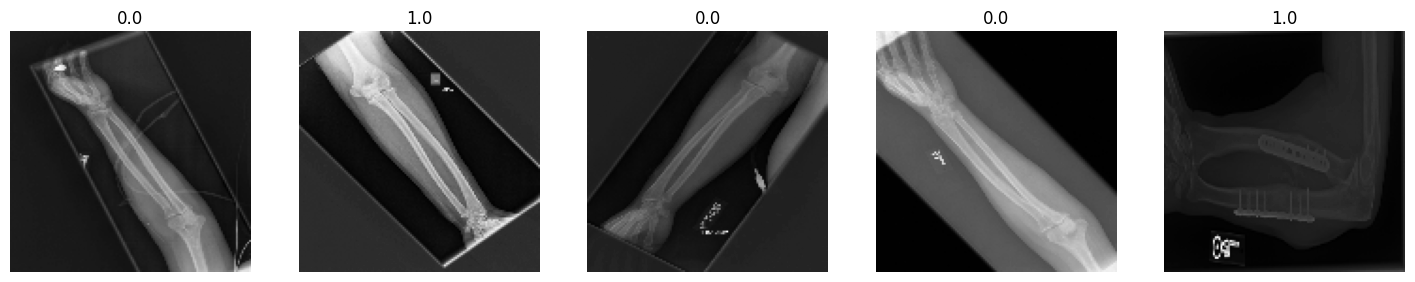

Labels: [0. 1. 0. 0. 1.]


In [4]:
n_samples = 6

plt.figure(figsize=(18, 11))
for i in range(1, n_samples):
    plt.subplot(1, 5, i)
    sample_image = x_train[i]
    plt.imshow(sample_image, cmap='gray')
    plt.title(y_train[i])
    plt.axis("off")
plt.show()

print('Labels:', y_train[1:n_samples])

## Define Model Architecture

In [5]:
def predictions(caps_Lminus1, dims_Lminus1, output_Lminus1,
                caps_L, dims_L, batch_size, weight_sharing=False, grid_cells_Lminus1=1, name=None):
    with tf.name_scope(name, default_name="predictions"):
        if weight_sharing == False:
            output_Lminus1 = tf.squeeze(output_Lminus1, axis=[1, 4], name="output_Lminus1")

        init_sigma = 0.1
        W_init = tf.random_normal(shape=(1, caps_Lminus1, caps_L, dims_L, dims_Lminus1),
                                  stddev=init_sigma, dtype=tf.float32, name="W_init")
        W = tf.Variable(W_init, name="W")
        tf.summary.histogram("W", W)

        W_tiled = tf.tile(W, [batch_size, grid_cells_Lminus1, 1, 1, 1], name="W_tiled")
        output_expanded_Lminus1 = tf.expand_dims(output_Lminus1, -1, name="output_expanded_Lminus1")
        output_tile_Lminus1 = tf.expand_dims(output_expanded_Lminus1, 2, name="output_tile_Lminus1")
        output_tiled_Lminus1 = tf.tile(output_tile_Lminus1, [1, 1, caps_L, 1, 1], name="output_tiled_Lminus1")
        predicted_L = tf.matmul(W_tiled, output_tiled_Lminus1, name="predicted_L")

        return predicted_L

def routing(caps_Lminus1, caps_L, batch_size, iterations, predicted_L, name=None):
    with tf.name_scope(name, default_name="routing"):
        raw_weights = tf.zeros([batch_size, caps_Lminus1, caps_L, 1, 1], dtype=np.float32, name="raw_weights")

        for r in range(0, iterations):
            routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")
            weighted_predictions = tf.multiply(routing_weights, predicted_L, name="weighted_predictions")
            weighted_sum = tf.reduce_sum(weighted_predictions, axis=(1), keepdims=True, name="weighted_sum")
            output_L = squash(weighted_sum, axis=-2, name="output_L")
            output_tiled_L = tf.tile(output_L, [1, caps_Lminus1, 1, 1, 1], name="output_tiled_L")
            agreement = tf.matmul(predicted_L, output_tiled_L, transpose_a=True, name="agreement")
            raw_weights = tf.add(raw_weights, agreement, name="raw_weights")

        return output_L, routing_weights

def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keepdims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

X = tf.placeholder(shape=[None, None, None, input_dimensions[2]], dtype=tf.float32, name="X")
tf.summary.image('X', X)
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

# Block 1
k = 3
s = 1
x = tf.layers.Conv2D(128, k, s, activation='relu')(X)
x = tf.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

# Block 2
k = 3
s = 1
x = tf.layers.Conv2D(256, k, s, activation='relu')(x)
x = tf.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

# Block 3
k = 7
s = 1
convcaps_dims = 16
convcaps_caps_types = 32
convcaps = tf.layers.Conv2D(convcaps_dims*convcaps_caps_types, k, s, name="convcaps")(x)
tf.summary.histogram("convcaps", convcaps)

convcaps_grid_length = tf.shape(convcaps)[1]
convcaps_grid_width = tf.shape(convcaps)[2]
convcaps_grid_cells = convcaps_grid_length * convcaps_grid_width
convcaps_caps = convcaps_caps_types * convcaps_grid_cells

convcaps_reshape = tf.reshape(convcaps, [-1, convcaps_caps, convcaps_dims], name="convcaps_reshape")
convcaps_output = squash(convcaps_reshape, name="convcaps_output")

batch_size = tf.shape(X)[0]

# If doing more than 1 capsule layer caps1_caps doesn't need to be the num_classes
caps1_caps = num_classes
caps1_dims = 12

caps1_predictions = predictions(convcaps_caps_types, convcaps_dims, convcaps_output,
                                caps1_caps, caps1_dims, batch_size, True, convcaps_grid_cells, "caps1_predictions")

caps1_output, routing1 = routing(convcaps_caps, caps1_caps,
                                 batch_size, 6, caps1_predictions, "routing1")

# You Can Add More Capsule Layers By Doing:
# Adding a second layer:
# -----------------------
# caps2_caps = 8
# caps2_dims = 16
# 
# caps2_predictions = predictions(caps1_caps, caps1_dims, caps1_output, 
#                                 caps2_caps, caps2_dims, batch_size, False, 1, "caps2_predictions")
#                                                                       ^ remains as False
# caps2_output, routing2 = routing(caps1_caps, caps2_caps, batch_size, 9, caps2_predictions, "routing2")
# 
# Adding a third layer:
# -----------------------
# caps3_caps = num_classes
# caps3_dims = 16
# 
# caps3_predictions = predictions(caps2_caps, caps2_dims, caps2_output, 
#                                 caps3_caps, caps3_dims, batch_size, False, 1, "caps3_predictions")
# 
# 
# caps3_output, routing3 = routing(caps2_caps, caps3_caps, batch_size, 9, caps3_predictions, "routing3")
# 
# Then Modify The Variable Below As Needed

# This Line Is Here To Make Using More Capsules Work Without Modifying Variables Below!
final_capsule_output, final_routing_output = caps1_output, routing1

with tf.name_scope(name="accuracy_cell"):
    lengths_temp = safe_norm(final_capsule_output, axis=-2, name="lengths_temp")
    lengths = tf.reshape(lengths_temp, shape=(-1, num_classes), name="lengths")
    lengths_argmax = tf.argmax(lengths, axis=1, name="lengths_argmax")
    y_predictions = lengths_argmax
    correct = tf.equal(y, y_predictions, name="correct")
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    tf.summary.scalar('accuracy', accuracy)

m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

with tf.name_scope(name="loss_cell"):
    T = tf.one_hot(y, depth=caps1_caps, name="T")
    # Compute norm of each capsule in digitcaps
    caps1_output_norm = safe_norm(final_capsule_output, axis=-2, keep_dims=True, name="caps1_output_norm")

    present_error_raw = tf.square(tf.maximum(0., m_plus - caps1_output_norm), name="present_error_raw")
    present_error = tf.reshape(present_error_raw, shape=(-1, caps1_caps), name="present_error")
    # -1 tells reshape to calculate the size of this dimension.

    absent_error_raw = tf.square(tf.maximum(0., caps1_output_norm - m_minus), name="absent_error_raw")
    absent_error = tf.reshape(absent_error_raw, shape=(-1, caps1_caps), name="absent_error")
    # -1 tells reshape to calculate the size of this dimension.

    # Compute Margin Loss
    L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error, name="L")
    loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="loss")
    tf.summary.scalar('loss', loss)

# ### Adam Optimizer
# Initialize adam optimizer to minimize $\texttt{loss}$.
with tf.name_scope(name="train"):
    learning_rate = tf.placeholder(tf.float32, shape=[])
    tf.summary.scalar('learning_rate', learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss, name="training_op")







Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
merged_summary = tf.summary.merge_all()
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Save model and tensorboard data to this folder
folder = folder_name + str(batchSize) + "_lr" + str(lr)

# Load time step for Tensorboard.
if os.path.isfile('./tensorboard/Models/' + folder + '/time_step.pickle'):
    time_step_unpickle = open('./tensorboard/Models/' + folder + '/time_step.pickle', 'rb')
    time_step = pickle.load(time_step_unpickle)
else:
    time_step = 0

# Load learning rate
if os.path.isfile('./tensorboard/Models/' + folder + '/learning_r.pickle'):
    learning_r_unpickle = open('./tensorboard/Models/' + folder + '/learning_r.pickle', 'rb')
    lr = pickle.load(learning_r_unpickle)

print('time step: ', time_step)
print('learning rate: ', lr)




time step:  0
learning rate:  0.001


# This cell begins training the model

In [7]:
n_iterations_per_epoch = len(x_train) // batchSize
n_iterations_validation = len(x_val) // batchSize
best_loss_val = np.infty

if not os.path.exists("./tensorboard/Models/" + folder):
    os.makedirs("./tensorboard/Models/" + folder)
checkpoint_path = "./tensorboard/Models/" + folder + "/my_capsule_network"

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
    writer = tf.summary.FileWriter("./tensorboard/" + folder)
    writer.add_graph(sess.graph, global_step=time_step)

    lr_count = 0
    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):  # [:300]
            X_batch = x_train[(batchSize * (iteration - 1)):(batchSize * iteration)]
            y_batch = y_train[(batchSize * (iteration - 1)):(batchSize * iteration)]

            # Every 5 iterations display loss
            if time_step % 5 == 0:
                loss_, merged_summary_, y_predictions_, y_ = sess.run(
                    [loss, merged_summary, y_predictions, y],
                    feed_dict={X: X_batch.reshape([-1, input_dimensions[0], input_dimensions[1], input_dimensions[2]]),
                               y: y_batch,
                               learning_rate: lr})
                writer.add_summary(merged_summary_, time_step)
                print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.6f}  Prediction: {}  y: {}".format(
                    iteration, n_iterations_per_epoch, iteration * 100 / n_iterations_per_epoch,
                    loss_, y_predictions_, y_), end="")

            # Train Model
            _ = sess.run([training_op], feed_dict={X: X_batch.reshape([-1, input_dimensions[0], input_dimensions[1], input_dimensions[2]]),
                                                   y: y_batch,
                                                   learning_rate: lr})

            time_step = time_step + 1

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch = x_val[(batchSize * (iteration - 1)):(batchSize * iteration)]
            y_batch = y_val[(batchSize * (iteration - 1)):(batchSize * iteration)]
            loss_val, acc_val = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, input_dimensions[0], input_dimensions[1], input_dimensions[2]]),
                           y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                iteration, n_iterations_validation,
                iteration * 100 / n_iterations_validation),
                end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val
        else:
            lr_count = lr_count + 1

            if lr_count == 3:
                lr = lr / 10
                lr_count = 0
                print(lr)

                with open('./tensorboard/Models/' + folder + '/lr.pickle', 'wb') as f:
                    pickle.dump(lr, f, protocol=pickle.HIGHEST_PROTOCOL)

                if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
                    saver.restore(sess, checkpoint_path)

        with open('./tensorboard/Models/' + folder + '/time_step.pickle', 'wb') as f:
            pickle.dump(time_step, f, protocol=pickle.HIGHEST_PROTOCOL)


Instructions for updating:
Use standard file APIs to check for files with this prefix.

Epoch: 1  Val accuracy: 49.2188%  Loss: 0.404999 (improved)1 1 1 1 1 1 1 1 1 1 1 1 1 1]  y: [1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 1]
Epoch: 2  Val accuracy: 49.2188%  Loss: 0.404999 (improved)1 1 1 1 1 1 1 1 1 1 1 1 1 1]  y: [1 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1]
Epoch: 3  Val accuracy: 49.2188%  Loss: 0.404999 (improved) 1 1 1 1 1 1 1 1 1 1 1 1 1 1]  y: [0 1 0 1 0 0 1 1 0 0 0 1 0 0 1 1]
Epoch: 4  Val accuracy: 49.2188%  Loss: 0.404999 (improved)1 1 1 1 1 1 1 1 1 1 1 1 1 1]  y: [0 0 0 1 1 1 1 0 0 1 1 1 0 1 0 1]
Epoch: 5  Val accuracy: 49.2188%  Loss: 0.404999 (improved)1 1 1 1 1 1 1 1 1 1 1 1 1 1]  y: [0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0]
Epoch: 6  Val accuracy: 49.2188%  Loss: 0.404992 (improved)1 1 1 1 1 1 1 1 1 1 1 1 1 1]  y: [1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 1]
Epoch: 7  Val accuracy: 49.2188%  Loss: 0.404999tion: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]  y: [1 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1]
Epoch: 8  Val accuracy: 49.2

## Evaluate Model On Test Data

In [8]:
test_data = r"C:\Users\Michael\Desktop\Model Benchmark\data\Mura\test.h5"

x_test, y_test = load_data(test_data)

x_test = x_test.reshape((-1, input_dimensions[0], input_dimensions[1], input_dimensions[2])).astype('float32') / 255.
y_test = y_test.astype('float32')

n_iterations_test = len(x_test) // batchSize

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    loss_tests = []
    acc_tests = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = x_test[
                           (batchSize * (iteration - 1)):(batchSize * iteration)], y_test[
                                                                                     (batchSize * (
                                                                                                 iteration - 1)):(
                                                                                             batchSize * iteration)]
        loss_test, acc_test = sess.run(
            [loss, accuracy],
            feed_dict={X: X_batch.reshape([-1, input_dimensions[0], input_dimensions[1], input_dimensions[2]]),
                       y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
            iteration, n_iterations_test,
            iteration * 100 / n_iterations_test),
            end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))

INFO:tensorflow:Restoring parameters from ./tensorboard/Models/MuraForeArm16_lr0.001/my_capsule_network
Final test accuracy: 50.0000%  Loss: 0.404983
